In [1]:
import geopandas as gpd
import numpy as np
import os
import rioxarray
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Introduction

In this tutorial, a simple model is trained on a small dataset, to present the usage of the levee-hunter package.

For a more in-depth look at how this data looks like and how masks are being prepared, take a look at the notebooks 1.0, 1.1, 1.2.

### Task: hunting for the levees (flood barriers)
We want to be able to find levees which are not in the database using satelite images. For this task we use existing levee database and Lidar images to train a Machine Learning model, which takes a Lidar image as an input and classifies each pixel as either belonging to the background or levee classes. 

This is therefore a Semantic Segmentation task.

# 1. Import Data

Data consists of Lidar images in .tif format as well as levee database from the same region, which can be read in using geopandas.

In [2]:
# Load the Lidar images
data_dir = "../data/raw/w2-Lidar"
tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
images = [
    rioxarray.open_rasterio(os.path.join(data_dir, file)) for file in tif_files[:]
]

print(len(images))

22


In [3]:
# We can check the crs (Coordinate Reference System) of the images,
# in this case each of them has the same crs
print(images[0].rio.crs)

EPSG:3717


In [4]:
# Load the levees data and convert it to the same crs as the images
levees_file = "../data/raw/w1-Kickoff/us_levees_n38w122.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_3717 = levees_data.to_crs("EPSG:3717")

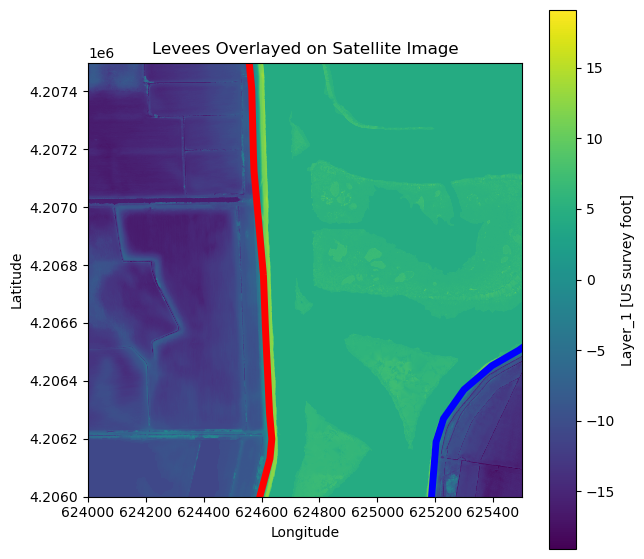

In [5]:
# Now we can plot an example image and overlay the levees that are in the same area
# As can be seen, two different levees are present in the image

fig, ax = plt.subplots(figsize=(7, 7))
img = images[8]
img.plot(ax=ax, cmap="viridis")

# Overlay the levee data
levees_data_3717.iloc[9:10].plot(ax=ax, color="red", linewidth=5)
levees_data_3717.iloc[32:33].plot(ax=ax, color="blue", linewidth=5)

plt.title("Levees Overlayed on Satellite Image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 2. Prepare Masks (Targets) for Training

Next we use can use get_mask function over the images to create masks for each of them. This function takes a Lidar image as an input and a levee database. Then it returns a mask for this image, which represents which pixels ideally should be marked as belonging to the levee class.

In [6]:
# Loop over images and for each of them get their mask using get_mask:

from levee_hunter.get_mask import get_mask


lidar_images_arr = []
targets_arr = []
for image in images:
    lidar_data, target = get_mask(
        image, levees_data_3717, invert=True, dilation_size=20
    )
    lidar_data = lidar_data.reshape(lidar_data.shape[1], lidar_data.shape[2])
    lidar_images_arr.append(lidar_data)
    targets_arr.append(target)

lidar_images_arr = np.array(lidar_images_arr)
targets_arr = np.array(targets_arr)

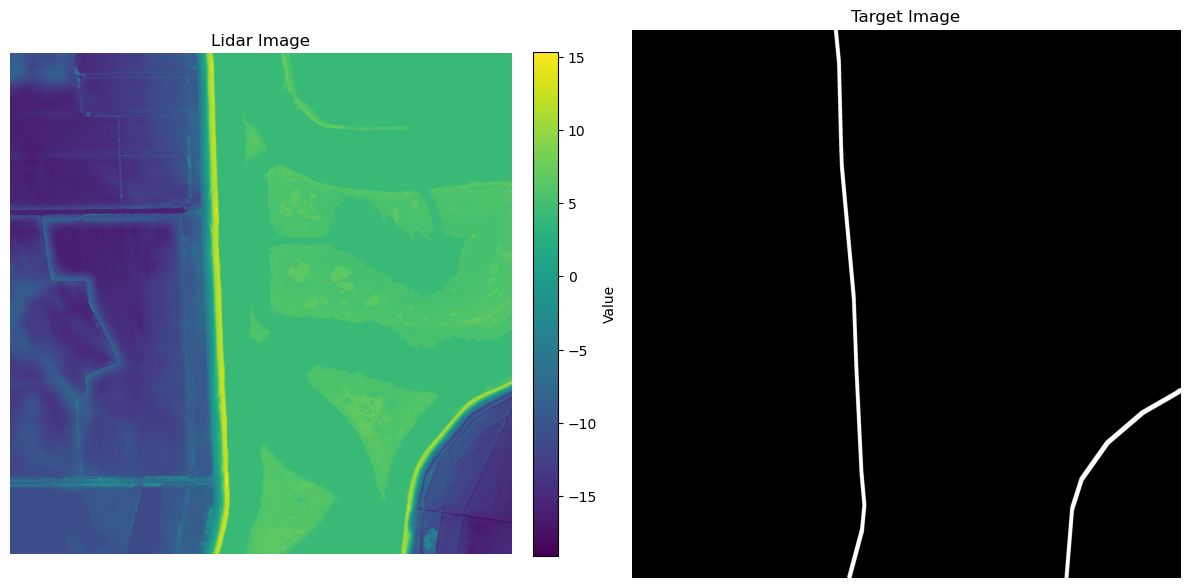

In [7]:
# Now we can plot an example mask and the corresponding image,
# as can be seen the white lines match the levees in the image

from levee_hunter.plots import plot_img_and_target

plot_img_and_target(lidar_images_arr[8], targets_arr[8])

In [8]:
# We have 22 images each (3000, 3000) in shape.
# The same is also true for targets
lidar_images_arr.shape, targets_arr.shape

((22, 3000, 3000), (22, 3000, 3000))

# 3. Splitting into smaller images

Currently, each image and its target, have shapes (3000, 3000). This might be too large for gradient calculations. Additionally segmentation models often require shape divisible by 32. Therefore we need to split our images into smaller ones, while ensuring that the shape is divisible by 32. This task of course might not be possible with full 3000 x 3000 pixels image. 

To find optimal splits, a function find_splits can be used. It assumes the images are squares and reduces the problem to splitting a line of length Z (in pixels) into n smaller lines each of length s, with some overlap between them. The function takes original length Z as input, together with the desired smaller length s, and the max_overlap_frac. 

It will then try to choose such overlap, that the maximum length is covered by the smaller lengths s, which is not always the full original length Z. If we just tried to minimize loss of pixels, sometimes very large overlap might be recommended, which would mean the same area might be showed to the model more than once. To limit this, max_overlap_frac parameter is used, which limits how large overlap can be recommended, as a fraction of the smaller image side s.

In [9]:
# Recommend splits to the user based on the desired smaller image size

from levee_hunter.utils import find_splits

find_splits(Z=3000, s=512, max_overlap_frac=0.1)[:8]

n, overlap, total_covered


[(6, 15, 2997),
 (6, 16, 2992),
 (6, 17, 2987),
 (6, 18, 2982),
 (6, 19, 2977),
 (6, 20, 2972),
 (6, 21, 2967),
 (6, 22, 2962)]

We pick the top recommended option, and proceed to create a dataset using that. 

The SegmentationDataset class has self.split_and_pad method which is called in the __init__ if the argument split is set to True (default = False).

This method will split each original larger image into smaller images of the desired final_size. Function will also pad to shape divisible by 32. to prevent padding, user should select patch_size and final_size to be the same and both divisible by 32. A warning will be given if unintended padding occurs.

SegmentationDataset has the expected __len__ and __getitiem__ methods required for DataLoader for model training. In addition it also has useful methods for removing images which have target without any levees on them (just background) and removing images with invalid values which might occur if data was missing in given region. There is also a plotting method for visualisation.

In [10]:
# Create dataset

from levee_hunter.segmentation_dataset import SegmentationDataset

img_dataset = SegmentationDataset(
    images=lidar_images_arr,
    targets=targets_arr,
    transform=None,
    split=True,
    patch_size=512,
    final_size=512,
    overlap=15,
)

len(img_dataset)  # 6^2 * 22 = 792

792

In [11]:
# Lets remove any potentially invalid images, although here there are none

img_dataset.remove_invalid_images()
len(img_dataset)

792

Most images created this way will contain only background (no levees). 

This has the risk, that model will simply learn to predict background everywhere. Therefore SementationDataset has a method which limits this effect by removing such images from dataset. The method self.remove_empty(keep_empty=0.0) has an argument keep_empty to allow some of those empty images with no levees on them, to still be kept. 

This is because we still want model to be able to deduce there are no levees on an image, given an image with no levees on them. The value of this parameter determines how many empty images are kept, based on the size of the non empty database, for example if there are 100 non empty images, keep_empty=0.2 would result in 20 empty images added to the self.images database.

In [12]:
# Removing empty images, while keeping some with keep_empty=0.2

img_dataset.remove_empty(keep_empty=0.2)
len(img_dataset)

232

# 4. Selecting Data

Not all levees are in the database, therefore there is a risk of using a Lidar image with levee on it during training, while the mask would suggest there is no levee in that place. This would confuse the model and it would be best to avoid this. Therefore now we can manually look at the images in the database and select those we would want to keep. 

The function below is used to perform this. It shows an image and its target to the user and the user can decide:
- Yes (y): to keep this image in the database
- Special (s): to mark certain images as special, here for example we mark those images which we are strongly convinced no levees are missing on them
- No (n) to reject such image (eg if there are missing levees on it)

The function outputs indices of images which were selected, and which were marked as special. 

Note: this can be done at the step with larger images, the benefit would be that user would need to go through fewer images, but rejecting entire image would reduce the dataset more with larger images.

Important: Note that marking image as special will also incluse it in the selected

If you wish to skip this selection process, go to section 5. Loading Data.

In [ ]:
from levee_hunter.utils import interactive_labeling

selected, special = interactive_labeling(img_dataset)

Label(value='')

Output()

Button(description='Yes (y)', style=ButtonStyle())

Button(description='Special (s)', style=ButtonStyle())

Button(description='No (n)', style=ButtonStyle())

Button(description='Quit (q)', style=ButtonStyle())

In [14]:
len(selected), len(special)

(206, 22)

Now based on the selected and special images, we create datasets:

In [15]:
# Convert selected indices to a set for efficient lookup
selected_set = set(selected)

# Find all indices that were NOT selected
all_indices = set(range(len(img_dataset.images)))
bad_indices = list(all_indices - selected_set)  # Get unselected indices

# Extract images and targets
good_imgs = np.array([img_dataset.images[i] for i in selected])
good_targets = np.array([img_dataset.targets[i] for i in selected])

special_imgs = np.array([img_dataset.images[i] for i in special])
special_targets = np.array([img_dataset.targets[i] for i in special])

bad_imgs = np.array([img_dataset.images[i] for i in bad_indices])
bad_targets = np.array([img_dataset.targets[i] for i in bad_indices])

good_imgs.shape, good_targets.shape

((206, 1, 512, 512), (206, 1, 512, 512))

We can now weight the images, depending on how we selected them:

In [45]:
# Define weights (higher for special images)
weights = torch.ones(len(good_imgs))  # Default weight = 1
special_indices_set = set(special)

# Assign higher weight (e.g., 2x) to special images
for i, idx in enumerate(selected):
    if idx in special_indices_set:
        weights[i] = 2.0  # Increase weight

In [46]:
# Lets take a look at the first few weights:
weights[:20]

tensor([1., 2., 1., 2., 1., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1., 2., 1., 1.,
        1., 1.])

In [47]:
# Now we create dataset with only the selected images:

good_dataset = SegmentationDataset(
    images=good_imgs, targets=good_targets, transform=None, split=False
)

len(good_dataset)

206

In [48]:
better_dataset = SegmentationDataset(
    images=special_imgs, targets=special_targets, transform=None, split=False
)

len(better_dataset)

22

In [49]:
bad_dataset = SegmentationDataset(images=bad_imgs, targets=bad_targets, transform=None)

len(bad_dataset)

26

In [ ]:
# Assign weights to the good dataset
good_dataset.weights = weights

We can save the datasets, to not have to repeat all the manual choosing accidentally.

In [51]:
torch.save(good_dataset, "../data/processed/tutorial_data/good_dataset_1m_512.pth")
torch.save(better_dataset, "../data/processed/tutorial_data/better_dataset_1m_512.pth")
torch.save(bad_dataset, "../data/processed/tutorial_data/bad_dataset_1m_512.pth")

# 5. Loading Data

In [13]:
good_dataset = torch.load("../data/processed/tutorial_data/good_dataset_1m_512.pth", weights_only=False)
better_dataset = torch.load("../data/processed/tutorial_data/better_dataset_1m_512.pth", weights_only=False)
bad_dataset = torch.load("../data/processed/tutorial_data/bad_dataset_1m_512.pth", weights_only=False)

# 6. Augmentations

We can add augmentations for better training. Useful augmentations have been defined inside levee_hunter.augmentations and now we can assign them to the datasets:

In [14]:
from levee_hunter.augmentations import train_transform, normalize_only

# Set transforms, for training use augmentations, for testing just normalize
good_dataset.transform = train_transform
better_dataset.transform = train_transform
bad_dataset.transform = normalize_only

/home/pmucha/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:12: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(


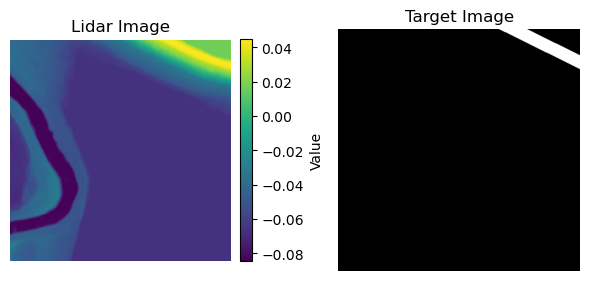

In [15]:
# Example plot, transform=True means that transformation is enabled
# They have certain chance of occuring so running this cell a few times
# can give an idea of the possible augmentations

better_dataset.plot(2, transform=True)

# 7. Creating Training Dataset

Now that we have a dataset (good_dataset) with the selected images which we can trust. We can split that into training and testing. 

The train_test_split_dataset function, takes a SegmentationDataset inastance as an input and splits it into training and testing datasets. 

If the orignal dataset had weights, then training dataset returned by this function will keep appropriate weights, corresponding to the images kept. Additionally, the training dataset will keep the transformation of the original dataset, and a warning is given to the user in case it was set to None. Validation dataset does not need weights, and its transformation is set to normalize_only. 

In [16]:
from levee_hunter.train_test_split_dataset import train_test_split_dataset

training_dataset, val_dataset = train_test_split_dataset(good_dataset, test_size=0.15)

len(training_dataset), len(val_dataset)

(175, 31)

In [17]:
training_dataset.weights[:20]

tensor([1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [18]:
training_dataset.transform

Compose([
  HorizontalFlip(p=0.5),
  VerticalFlip(p=0.5),
  RandomRotate90(p=0.5),
  ShiftScaleRotate(p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-15, 15), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
  ElasticTransform(p=0.5, interpolation=1, mask_interpolation=0, keypoint_remapping_method='mask', alpha=1.0, sigma=50.0, approximate=False, same_dxdy=False, noise_distribution='gaussian'),
  Normalize(p=1.0, mean=0.0, std=1.0, max_pixel_value=255.0, normalization='standard'),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

# 8. Defining the Model

Now we can define a model which we want to use for this task. In this tutorial we choose the famous Unet model, which is available through segmentation_models.pytorch:

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
model = smp.Unet(
    encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

# 9. Training

In [25]:
# Choose batch size
batch_size = 50

# To enable weighted learning, set this to True
training_dataset.weights_return = True

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

train_loader.dataset.images[0].shape, len(train_loader.dataset.images)

((1, 512, 512), 175)

The train_model function can handle the training automatically for us. It will also save the best model to provided path. Best model is the one which achieved lowest validation loss.

If path is not provided, this function will automatically find the models/ directory within the root directory, and save the model named after its architecture (eg. Unet-model), followed by a letter if given name was taken, eg if name Unet-model_A was taken, the next one would be Unet-model_B.

This example does not have many images, so the training process is relatively fast, it should take ~80 minutes or less to run. This however also means, our model is not gonna be great. We used pretrained weights when defining the model and augmentations should also help a bit.

In [26]:
from levee_hunter.modeling.train import train_model

model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optim.Adam(model.parameters(), lr=1e-3),
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=25,
    save_model='best',
    save_model_path="../models/tutorial_model/tutorial_model.pth",
)

beginning training on device: cuda
Epoch: 1/25 Train Loss: 0.610957 Val Loss: 0.636990
Model successfully saved to: ../models/tutorial_model/tutorial_model.pth
Epoch: 2/25 Train Loss: 0.373928 Val Loss: 12.769599
Epoch: 3/25 Train Loss: 0.264275 Val Loss: 7.721625
Epoch: 4/25 Train Loss: 0.209463 Val Loss: 0.519656
Model successfully saved to: ../models/tutorial_model/tutorial_model.pth
Epoch: 5/25 Train Loss: 0.167671 Val Loss: 0.888779
Epoch: 6/25 Train Loss: 0.143628 Val Loss: 1.498527
Epoch: 7/25 Train Loss: 0.131066 Val Loss: 0.946594
Epoch: 8/25 Train Loss: 0.114954 Val Loss: 0.423512
Model successfully saved to: ../models/tutorial_model/tutorial_model.pth
Epoch: 9/25 Train Loss: 0.114549 Val Loss: 0.206646
Model successfully saved to: ../models/tutorial_model/tutorial_model.pth
Epoch: 10/25 Train Loss: 0.093565 Val Loss: 0.291283
Epoch: 11/25 Train Loss: 0.093139 Val Loss: 0.260184
Epoch: 12/25 Train Loss: 0.089063 Val Loss: 0.320034
Epoch: 13/25 Train Loss: 0.093390 Val Loss: 0

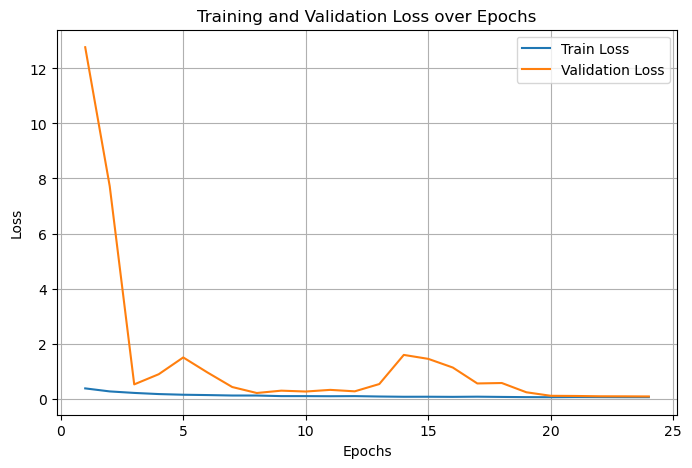

In [27]:
from levee_hunter.plots import plot_training_validation_loss

plot_training_validation_loss(train_loss[1:], val_loss[1:])

# 10. Predictions

Now we can apply the model on validation dataset which it did not see during training, to see how it is doing. It is important that the normalization of the images we want to predict on, is the same as the one used during training. This is why before when we did train_test_split_dataset, that function automatically set validation dataset's transformation to be normalize_only.

In [28]:
# load model
model_path = "../models/tutorial_model/tutorial_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# Set model to evaluation mode (important for inference)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

0


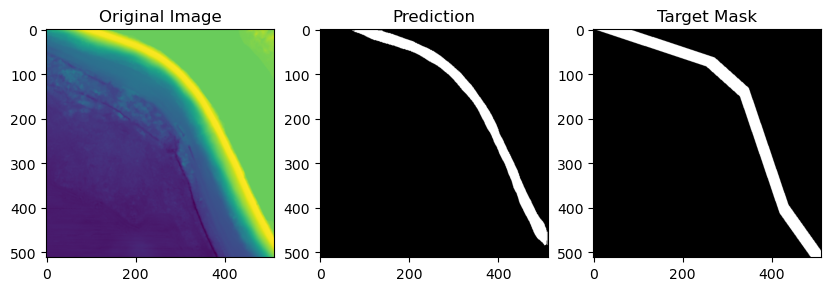

1


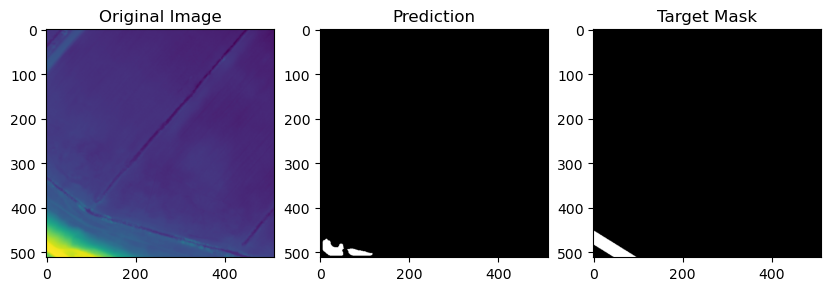

2


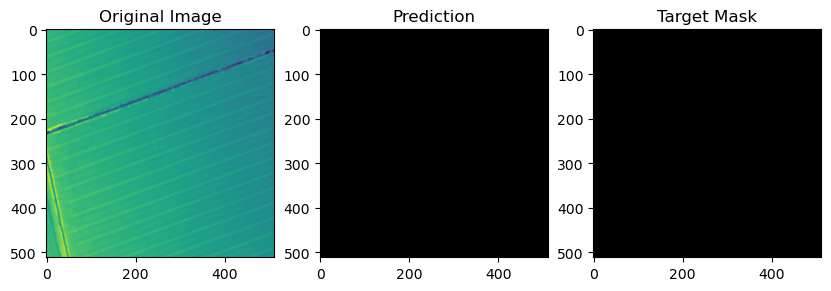

3


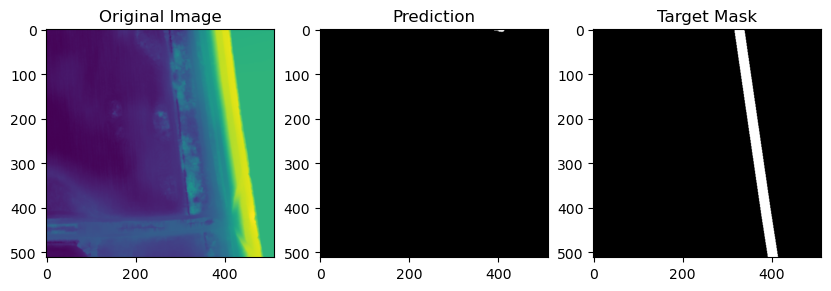

4


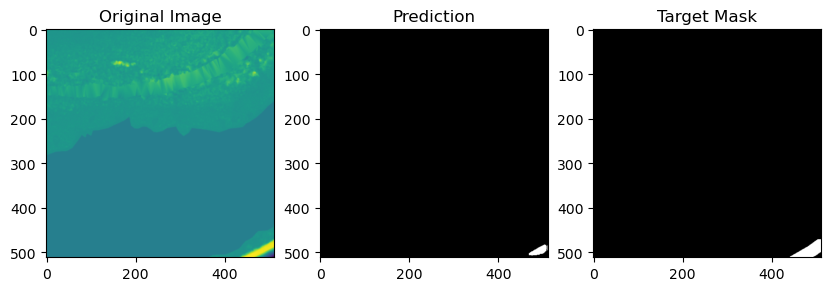

In [ ]:
from levee_hunter.plots import infer_and_visualize

for ix in range(5):
    sample_image, sample_mask = val_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)